In [1]:
# Cell 1 — Imports
import re
import numpy as np
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import chromadb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [2]:
# Cell 2 — Load Dataset
ds = load_dataset("7Xan7der7/us_airline_sentiment")
df = pd.DataFrame(ds["train"])

print(f"Rows: {len(df)}")
print(f"Sentiment distribution:\n{df['airline_sentiment'].value_counts()}")

Rows: 14640
Sentiment distribution:
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


SentenceTransformers doesn't understand <USER> or <URL> tokens
The presence of URL/mentions is already captured in has_url and mention_count (if you add them as features)
Simpler is better for embeddings

In [3]:
print("Before cleaning:")
print(f"  Rows: {len(df)}")
print(f"  Duplicates: {df.duplicated(subset=['text']).sum()}")
print(f"  NaN in text: {df['text'].isna().sum()}")
print(f"  Empty text: {(df['text'].str.strip() == '').sum()}")

# 2. Remove duplicates and NaN
df = df.drop_duplicates(subset=['text'])
df = df.dropna(subset=['text'])
df = df[df['text'].str.strip() != '']  # Remove empty strings

print(f"\nAfter cleaning: {len(df)} rows")

Before cleaning:
  Rows: 14640
  Duplicates: 213
  NaN in text: 0
  Empty text: 0

After cleaning: 14427 rows


In [4]:
# Cell 3 — Data Cleaning & Preprocessing

# 1. Check for issues
print("Before cleaning:")
print(f"  Rows: {len(df)}")
print(f"  Duplicates: {df.duplicated(subset=['text']).sum()}")
print(f"  NaN in text: {df['text'].isna().sum()}")
print(f"  Empty text: {(df['text'].str.strip() == '').sum()}")

# 2. Remove duplicates and NaN
df = df.drop_duplicates(subset=['text'])
df = df.dropna(subset=['text'])
df = df[df['text'].str.strip() != '']  # Remove empty strings

print(f"\nAfter cleaning: {len(df)} rows")

# 3. Minimal text preprocessing (for embeddings)
import re

def clean_text(text):
    text = re.sub(r"@\w+", "", text)          # Remove @mentions
    text = re.sub(r"http\S+|www\S+", "", text) # Remove URLs
    text = re.sub(r"\s+", " ", text).strip()   # Clean whitespace
    return text

df["text_clean"] = df["text"].apply(clean_text)

# 4. Remove rows where cleaned text is empty
df = df[df['text_clean'].str.strip() != '']
print(f"After text cleaning: {len(df)} rows")

# 5. Encode labels: negative=0, neutral=1, positive=2
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df["label"] = df["airline_sentiment"].map(label_map)

# Reset index
df = df.reset_index(drop=True)

print("\nSample:")
print(df[["text", "text_clean", "label"]].head(3))
print(f"\nLabel distribution:\n{df['label'].value_counts()}")

Before cleaning:
  Rows: 14427
  Duplicates: 0
  NaN in text: 0
  Empty text: 0

After cleaning: 14427 rows
After text cleaning: 14427 rows

Sample:
                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   

                                          text_clean  label  
0                                         What said.      1  
1  plus you've added commercials to the experienc...      2  
2  I didn't today... Must mean I need to take ano...      1  

Label distribution:
label
0    9080
1    3057
2    2290
Name: count, dtype: int64


In [5]:
# Cell 4 — Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"], df["label"],
    test_size=0.2, random_state=42, stratify=df["label"]
)

# Reset indices for consistency
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"Train: {len(X_train)} | Test: {len(X_test)}")

Train: 11541 | Test: 2886


In [6]:
# Cell 5 — Generate Embeddings
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
embedder = SentenceTransformer(model_name)

print("Generating train embeddings...")
train_embeddings = embedder.encode(X_train.tolist(), show_progress_bar=True)

print("Generating test embeddings...")
test_embeddings = embedder.encode(X_test.tolist(), show_progress_bar=True)

print(f"Shape: {train_embeddings.shape} (384 dims)")

Generating train embeddings...


Batches:   0%|          | 0/361 [00:00<?, ?it/s]

Generating test embeddings...


Batches:   0%|          | 0/91 [00:00<?, ?it/s]

Shape: (11541, 384) (384 dims)


In [7]:
# Cell 6 — Store in ChromaDB
import os
chroma_path = os.path.abspath("../chromadb_data")
chroma_client = chromadb.PersistentClient(path=chroma_path)

# Clean start
for name in ["train_embeddings", "test_embeddings"]:
    try:
        chroma_client.delete_collection(name)
    except:
        pass

# Create collections
train_col = chroma_client.create_collection("train_embeddings")
test_col = chroma_client.create_collection("test_embeddings")

# Add in batches (ChromaDB max is 5461)
batch_size = 5000

def add_in_batches(collection, embeddings, labels):
    for i in range(0, len(embeddings), batch_size):
        end = min(i + batch_size, len(embeddings))
        collection.add(
            ids=[str(j) for j in range(i, end)],
            embeddings=embeddings[i:end].tolist(),
            metadatas=[{"label": int(y)} for y in labels[i:end]]
        )
        print(f"  Added batch {i}-{end}")

print("Adding train embeddings...")
add_in_batches(train_col, train_embeddings, y_train)

print("Adding test embeddings...")
add_in_batches(test_col, test_embeddings, y_test)

print(f"\nStored: Train={train_col.count()} | Test={test_col.count()}")

Adding train embeddings...
  Added batch 0-5000
  Added batch 5000-10000
  Added batch 10000-11541
Adding test embeddings...
  Added batch 0-2886

Stored: Train=11541 | Test=2886


In [8]:
# Cell 7 — Retrieve & Train Logistic Regression
train_data = train_col.get(include=["embeddings", "metadatas"])
test_data = test_col.get(include=["embeddings", "metadatas"])

X_train_emb = np.array(train_data["embeddings"])
y_train_emb = np.array([m["label"] for m in train_data["metadatas"]])

X_test_emb = np.array(test_data["embeddings"])
y_test_emb = np.array([m["label"] for m in test_data["metadatas"]])

# Train
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_emb, y_train_emb)

print(f"Train accuracy: {clf.score(X_train_emb, y_train_emb):.4f}")

Train accuracy: 0.8463


In [9]:
# Cell 8 — Evaluate
y_pred = clf.predict(X_test_emb)

print(f"Test accuracy: {clf.score(X_test_emb, y_test_emb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_emb, y_pred, target_names=["negative", "neutral", "positive"]))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_emb, y_pred))

Test accuracy: 0.8198

Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.92      0.89      1816
     neutral       0.68      0.59      0.63       612
    positive       0.76      0.73      0.75       458

    accuracy                           0.82      2886
   macro avg       0.77      0.75      0.76      2886
weighted avg       0.81      0.82      0.82      2886


Confusion Matrix:
[[1666  111   39]
 [ 180  364   68]
 [  61   61  336]]


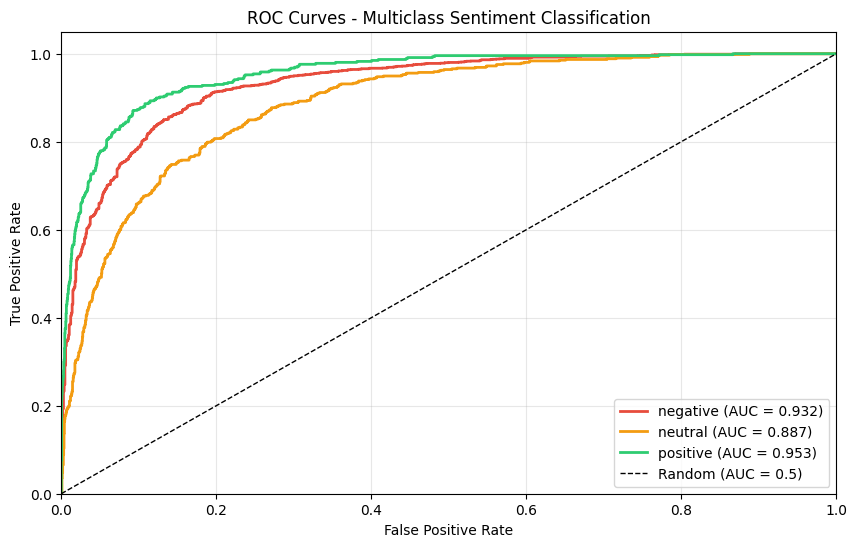


📊 AUC Scores:
  negative  : 0.9316
  neutral   : 0.8870
  positive  : 0.9531


In [10]:
# Cell — ROC Curve & AUC Score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Get probability predictions
y_proba = clf.predict_proba(X_test_emb)

# Binarize labels for multiclass ROC
y_test_bin = label_binarize(y_test_emb, classes=[0, 1, 2])
n_classes = 3
class_names = ['negative', 'neutral', 'positive']
colors = ['#e74c3c', '#f39c12', '#2ecc71']

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Multiclass Sentiment Classification')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Print AUC scores
print("\n📊 AUC Scores:")
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"  {class_names[i]:10}: {roc_auc:.4f}")


In [11]:
# Cell 9 — Save Model
import os
os.makedirs("../models", exist_ok=True)

joblib.dump(clf, "../models/logreg_embedding.joblib")
print("Model saved to ../models/logreg_embedding.joblib")

Model saved to ../models/logreg_embedding.joblib


In [ ]:
# Cell 10 — Quick Inference Test
def predict_sentiment(text):
    text_clean = clean_text(text)
    embedding = embedder.encode([text_clean])
    pred = clf.predict(embedding)[0]
    labels = {0: "negative", 1: "neutral", 2: "positive"}
    return labels[pred]

# Test
print(predict_sentiment("The flight was amazing!"))
print(predict_sentiment("Terrible service, never again."))
print(predict_sentiment("standard "))

positive
negative
neutral


: 